# Interpreting scvi batch correction in large donor studies

When datasets span multiple donors, experiments, and conditions, complex batch effects arise in the data from technical variation such as sequencing depth, protocol, and sample type. Batch effects are especially present for large datasets of 100+ donors.

This notebook demonstrates scVI's ability to integrate scRNA-seq data for one large donor study. We also interpret batch correction through the use of a batch embedding, and examine the "sensitivity to batch" of various genes.

## Setup and data

Import scvi and necessary prerequisites.

In [1]:
!pip install --quiet scvi-colab

     |████████████████████████████████| 229 kB 5.1 MB/s 
     |████████████████████████████████| 51 kB 6.6 MB/s 


In [2]:
from scvi_colab import install

install(branch="batch_embedding")

INFO     scvi-colab: Installing scvi-tools.                                                  
INFO     scvi-colab: Install successful. Testing import.                                     


Global seed set to 0


In [11]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import scvi
from anndata import AnnData

sc.set_figure_params(figsize=(4, 4))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In this notebook, we will use data from [Single-cell multi-omics analysis of the immune response in COVID-19 (Haniffa et al, 2021)](https://www.nature.com/articles/s41591-021-01329-2).

> Single-cell transcriptome, surface proteome and T and B lymphocyte antigen receptor analyses were performed for over 780,000 peripheral blood mononuclear cells from a cohort of 130 patients with varying severities of COVID-19. Data was gathered from 3 UK centers
> in Newcastle, Cambridge, and London, and controls included healthy volunteers, individuals with non-COVID-19 severe respiratory illness, and healthy volunteers administered with
> IV-LPS as a surrogate for inflammatory response.

In [4]:
import gdown

url = "https://drive.google.com/uc?id=1-_3nBzyMa2KgaMagmYodb4klGY-_Z_Zy"
output = "haniffa_50.h5ad"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1-_3nBzyMa2KgaMagmYodb4klGY-_Z_Zy
To: /content/haniffa_50.h5ad
100%|██████████| 579M/579M [00:03<00:00, 165MB/s]


'haniffa_50.h5ad'

## Model training

We load a subsampled version of the dataset containing cells from 50 patients. We choose to subsample mainly due to time constraints, since the full dataset takes a long time to train.

In [5]:
adata = sc.read("haniffa_50.h5ad")

In [6]:
adata

AnnData object with n_obs × n_vars = 289349 × 1200
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', '_scvi_batch', '_scvi_labels', 'leiden_bench', '_scvi_patient_id', '_scvi_initial_clustering'
    var: 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'Age_interval_colors', 'Sex_colors', 'Site_colors', 'Worst_Clinical_Status_colors', '_scvi', '_scvi_uuid', 'batch_embedding', 'hvg', 'initial_clustering_colors', 'leiden', 'metrics', 'model_training_time', 'neighbors', 'patient_id_colors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scvi', 'X_umap'
    varm: 'PCs'
    lay

We preprocess the data to remove genes that are very lowly expressed and other outliers.

In [7]:
sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)

We run `setup_anndata` to alert the model of batches and annotations in the dataset. We register the categorical covariate 'patient_id' as the batch key, so that the subsequent model will correct for batch effects by patient. The labels_key is 'initial_clustering', the coarse-level cell type annotations for each cell in the anndata.

In [8]:
scvi.model.SCVI.setup_anndata(
    adata, batch_key="patient_id", labels_key="initial_clustering"
)

We now create and train the model using the `use_batch_embedding` option.

In [9]:
model = scvi.model.SCVI(adata, use_batch_embedding=True)

In [10]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 28/28: 100%|██████████| 28/28 [09:40<00:00, 20.73s/it, loss=202, v_num=1]


## Batch effect visualization

We can use the scVI latent space to generate UMAP plots. This allows us to qualitatively assess our low-dimensional embedding of cells.

In [27]:
# This cell takes a long time to run, so we computed the neighbor graph and umap beforehand

# sc.pp.neighbors(adata)
# sc.tl.umap(adata, use_rep='X_scvi')

Below is a UMAP of the cells clustered by cell type. We see that cells of the same type are generally clustered together.

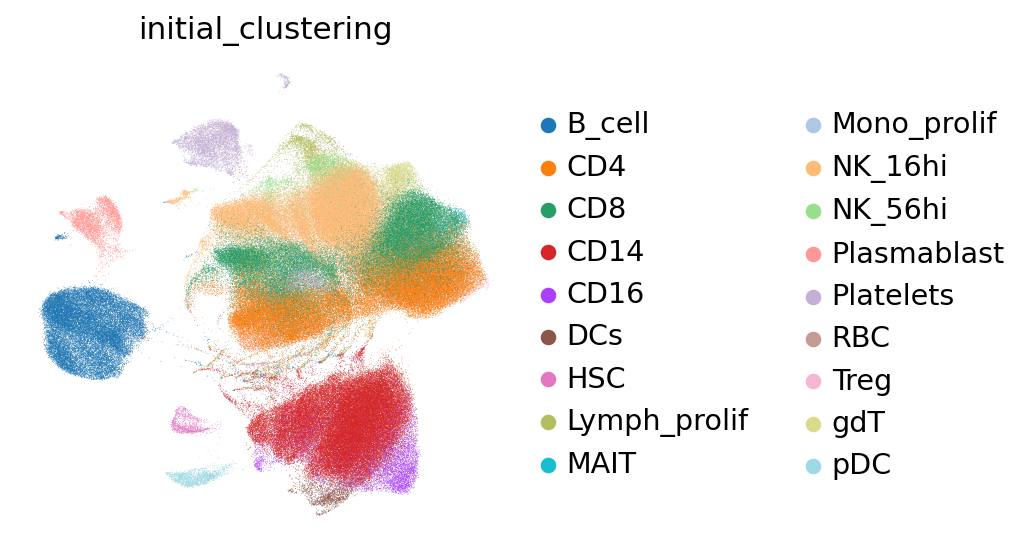

In [12]:
sc.pl.umap(
    adata,
    color=["initial_clustering"],
    frameon=False,
)

By coloring the UMAP by patient ID, we can see that some regions in the cell clusters are primarily one color (i.e. batchiness by patient). However, with 50 patients, it is hard to distinguish specific batch effects.

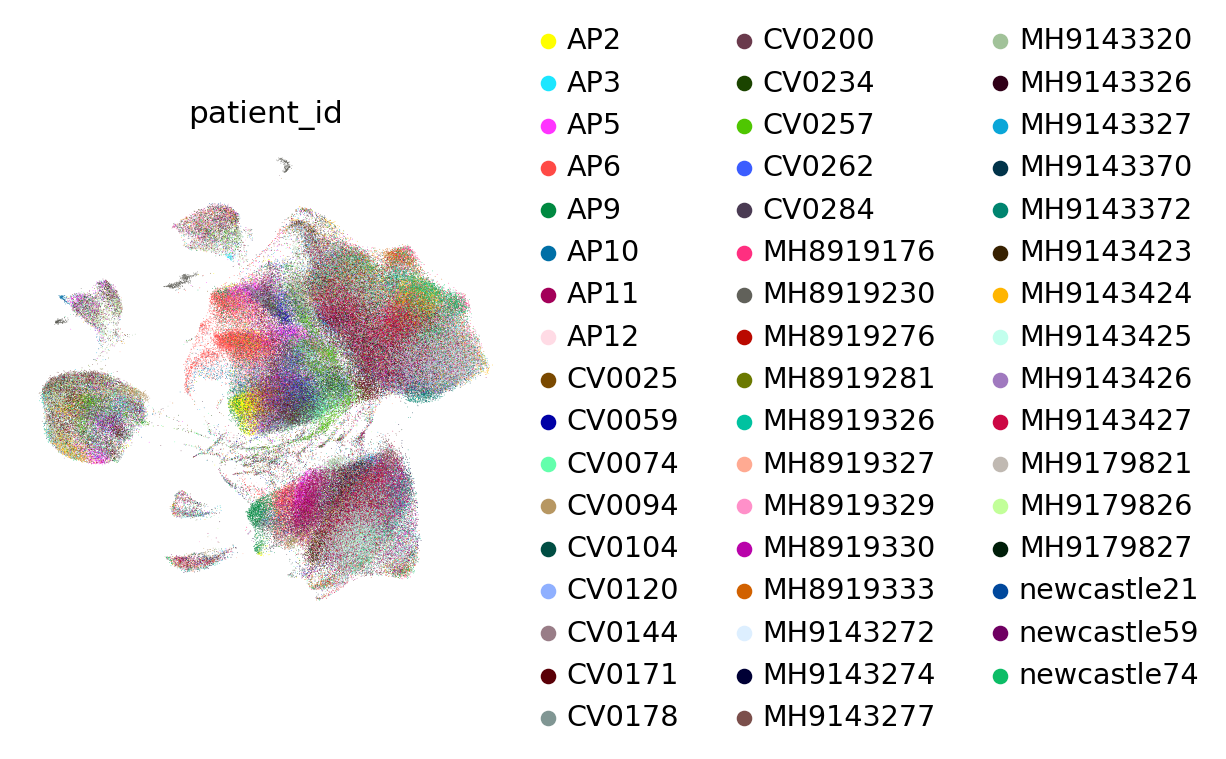

In [13]:
sc.pl.umap(
    adata,
    color=["patient_id"],
    frameon=False,
)

We now color the UMAP by different covariates. Looking at the UMAP plot for `Site`, there is noticeable stratification by site: orange Ncl cells, green Sanger cells, and blue Cambridge cells all stay within their own regions of the cluster for all 3 cell type clusters. This indicates the presence of batch effects resulting from technical variation (i.e. differences in how data was collected from each site). In an ideal world, the scVI model will account for these batch effects in the generative model.

The `Worst_Clinical_Status` covariate describes the worst clinical COVID-19 status experienced by the patient, and ranges from healthy to critical. Unlike the site covariate, this is an example of biological variation in patients that scVI should ideally keep in its model. Looking at stratification by clinical status, the cells for each status are generally well-mixed with the exception of the light blue cells. Examining more closely, we see that the stratification of light blue 'nan' cells is actually the same stratification we see with the Sanger site cells-- indicating that this variation is probably variation due to technical effects / sampling from the site.

For completeness, we also plot the `Sex` and `Age_Interval` covariates to see if there is any interesting variation by these biological factors. From the plots, the cells appear well-mixed for both.

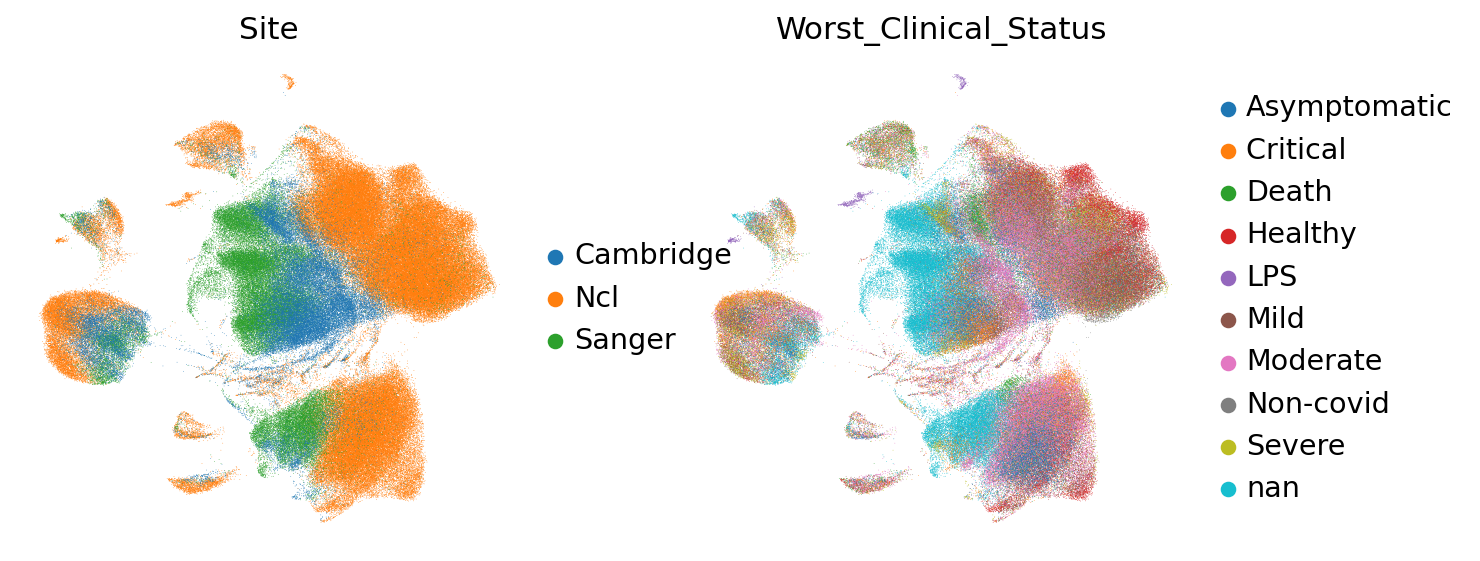

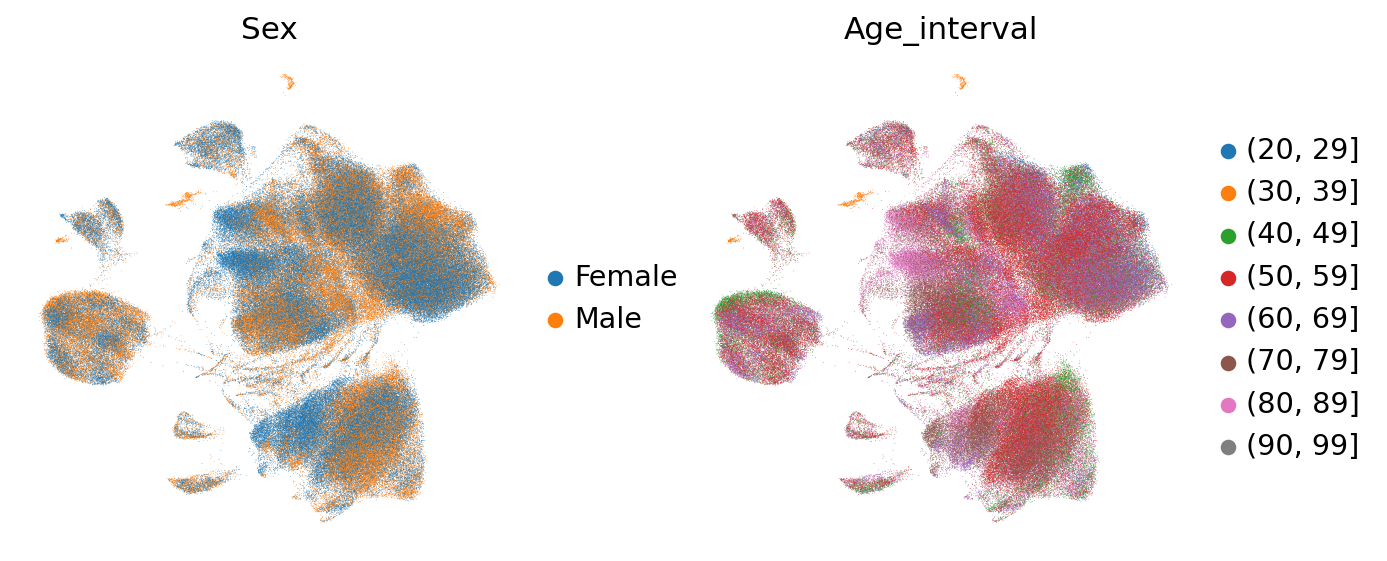

In [14]:
sc.pl.umap(
    adata,
    color=["Site", "Worst_Clinical_Status"],
    ncols=2,
    frameon=False,
)
sc.pl.umap(
    adata,
    color=["Sex", "Age_interval"],
    ncols=2,
    frameon=False,
)

## Batch embedding

In the `batch_embedding` version of scVI, batches are encoded by an embedding instead of a one-hot matrix. This representation encodes each batch in a 5-dimensional space, as shown below.
![one-hot vs. embedding](https://drive.google.com/uc?export=view&id=1BnMiLwGvniDd8atyBGTkzYfMpGuRzcDL)

We can get the batch embedding trained by the model to observe how the model handles batch effects.

In [16]:
batch_embedding = model.get_batch_embedding(adata, "patient_id")
batch_embedding.shape

(50, 5)

We convert the batch embedding to an Anndata object and create a UMAP from the batch embedding space.

In [17]:
be_adata = AnnData(batch_embedding)
sc.pp.neighbors(be_adata)
sc.tl.umap(be_adata)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


We can get the site and clinical status of each donor, and add that as a property to our batch embedding Anndata.

In [18]:
patient_adata = adata.obs.groupby("patient_id").first()

In [23]:
covariate_keys = ["Site", "Worst_Clinical_Status"]
for covariate in covariate_keys:
    be_adata.obs[covariate] = np.array(patient_adata[covariate])

Finally, we can plot the UMAPs colored by site and clinical status to see if the batch embedding reveals an underlying biological understanding of our donors.

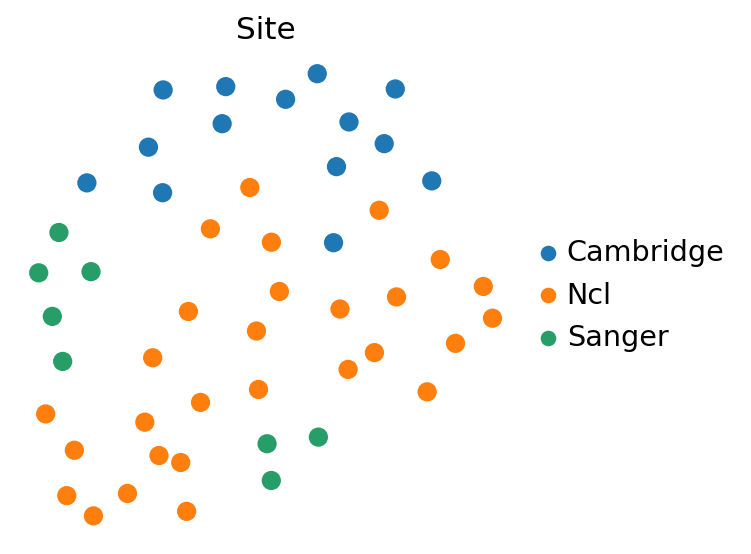

In [26]:
sc.pl.umap(
    be_adata,
    color="Site",
    size=300,
    frameon=False,
)

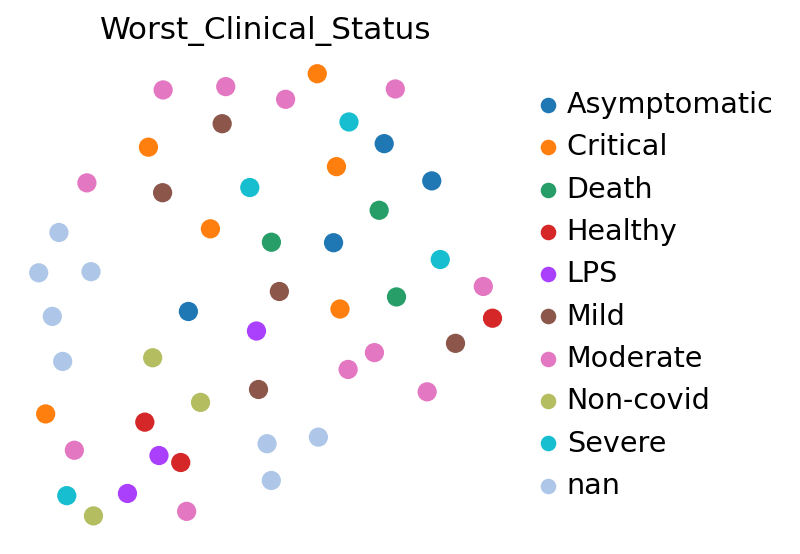

In [27]:
sc.pl.umap(
    be_adata,
    color="Worst_Clinical_Status",
    size=300,
    frameon=False,
)

From the batch embedding colored by "Site", we see that there is strong stratification of donors according to which site they were sampled from. This means that site is a major source of unwanted technical variation that scVI accounts for in its model. The "Worst_Clinical_Status"-colored embedding has less strong associations.

## Sensitivity to batch in gene expression data

We first choose a random subset of k = 10 donors from the dataset.

In [23]:
k = 10
donors = adata.obs["patient_id"].unique().tolist()
sample = random.sample(donors, k)
subset = adata[adata.obs["patient_id"].isin(donors)]
subset

View of AnnData object with n_obs × n_vars = 289331 × 1200
    obs: 'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id', '_scvi_batch', '_scvi_labels', 'leiden_bench', '_scvi_patient_id', '_scvi_initial_clustering', 'n_counts'
    var: 'feature_types', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'n_counts'
    uns: 'Age_interval_colors', 'Sex_colors', 'Site_colors', 'Worst_Clinical_Status_colors', '_scvi', '_scvi_uuid', 'batch_embedding', 'hvg', 'initial_clustering_colors', 'leiden', 'metrics', 'model_training_time', 'neighbors', 'patient_id_colors', 'pca', 'umap', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_pca_harmony', 

In [25]:
scvi.model.SCVI.setup_anndata(
    subset, batch_key="patient_id", labels_key="initial_clustering"
)

We then get the median normalized gene expression for each gene, conditioned on each possible donor: $P(g_j | z_j,b)$. We store this in a matrix of size `n_genes` x `n_donors`. By conditioning on each possible donor, we can see how the model batch corrects for the gene; i.e. a larger difference in expression across donors would mean that the model "batch corrects" more for that gene.

In [26]:
# takes several minutes to run
df = pd.DataFrame(columns=range(k))
for i, donor in enumerate(sample):
    print("getting expression conditioned on donor", i)
    df[i] = model.get_normalized_expression(subset, transform_batch=donor).median()
df

getting expression conditioned on donor 0
INFO     AnnData object appears to be a copy. Attempting to transfer setup.                  
getting expression conditioned on donor 1
getting expression conditioned on donor 2
getting expression conditioned on donor 3
getting expression conditioned on donor 4
getting expression conditioned on donor 5
getting expression conditioned on donor 6
getting expression conditioned on donor 7
getting expression conditioned on donor 8
getting expression conditioned on donor 9


,0,1,2,3,4,5,6,7,8,9
HES2,5.817523e-07,5.781493e-07,4.745894e-07,7.002179e-07,6.841859e-07,0.000001,0.000001,0.000001,2.661579e-07,5.560346e-07
AL358876.2,7.557122e-07,3.225897e-07,7.587675e-07,5.783209e-07,9.737764e-07,0.000001,0.000001,0.000001,9.657253e-07,7.172684e-07
SLC2A5,4.614167e-06,1.396622e-06,2.831621e-06,5.555057e-06,2.315606e-06,0.000006,0.000005,0.000004,2.905657e-06,5.924741e-06
SRM,1.752743e-04,1.975343e-04,1.251798e-04,9.646746e-05,1.055309e-04,0.000088,0.000090,0.000080,2.923200e-04,1.577590e-04
CELA2A,9.484002e-07,7.319197e-07,7.204150e-07,7.980344e-07,1.099165e-06,0.000001,0.000002,0.000002,4.715785e-07,9.065018e-07
...,...,...,...,...,...,...,...,...,...,...
AB_LGALS3,3.064961e-02,2.986199e-02,2.968700e-02,2.544444e-02,2.267774e-02,0.025518,0.026535,0.026902,2.648948e-02,3.038713e-02
AB_FCER2,1.032236e-02,1.163482e-02,1.079012e-02,1.272542e-02,1.234567e-02,0.012402,0.013437,0.013478,1.305542e-02,1.072374e-02
AB_Iglambda,1.779149e-02,1.421624e-02,1.786074e-02,1.354396e-02,1.523548e-02,0.017370,0.017328,0.018497,1.341849e-02,1.777449e-02
AB_C5AR1,1.515605e-02,1.462631e-02,1.380838e-02,1.404846e-02,1.393925e-02,0.014697,0.015793,0.014509,1.647769e-02,1.519951e-02


We now take the $\frac{std}{mean}$ across each $b$ in $P(g_j | z_j,b)$ to obtain the final "sensitivity to batch" score for each gene.

In [ ]:
s2b = df.std(axis=1).divide(df.mean(axis=1))

In [31]:
s2b.sort_values(ascending=False).head(10)

MTRNR2L8       2.776739
LINC01436      1.840950
IGHV1-69-2     1.481985
HBG1           1.241475
FOLR3          1.173611
S100A16        1.160136
TPSB2          1.129616
IGHV3OR16-8    1.095053
IFNB1          1.080317
CH25H          1.044061
dtype: float32

Above is a list of the top 10 "sensitive to batch" genes for this subset of donors. For consistency, we would want to run this experiment across multiple trials of donors to find a consensus ranking of the top genes (omitted from this notebook due to time constraints).

We can now look at individual genes from the "high S2B" gene list to see if there are interesting sources of variation.

In [39]:
expression = model.get_normalized_expression(subset)

In [40]:
expression["patient"] = adata.obs["patient_id"]
expression["covid"] = adata.obs["Worst_Clinical_Status"]
expression["site"] = adata.obs["Site"]

Let's examine how the MTRNR2L8 gene varies across sites. We can restrict our samples to only "moderate" COVID-19 patients, and then create a boxplot for the gene.

In [41]:
moderate_covid_expression = expression[expression["covid"] == "Moderate"]

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

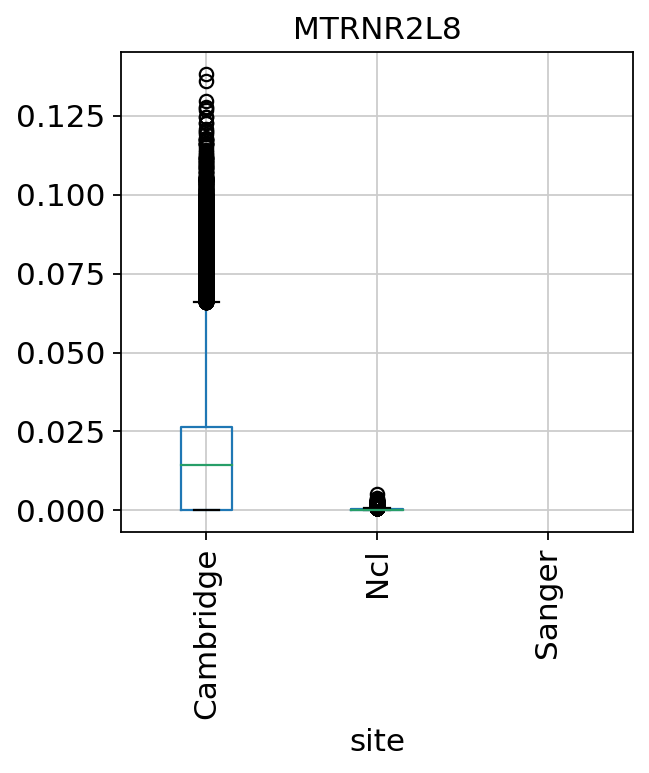

In [42]:
moderate_covid_expression.boxplot(by="site", column=["MTRNR2L8"], rot=90)
plt.suptitle("")

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

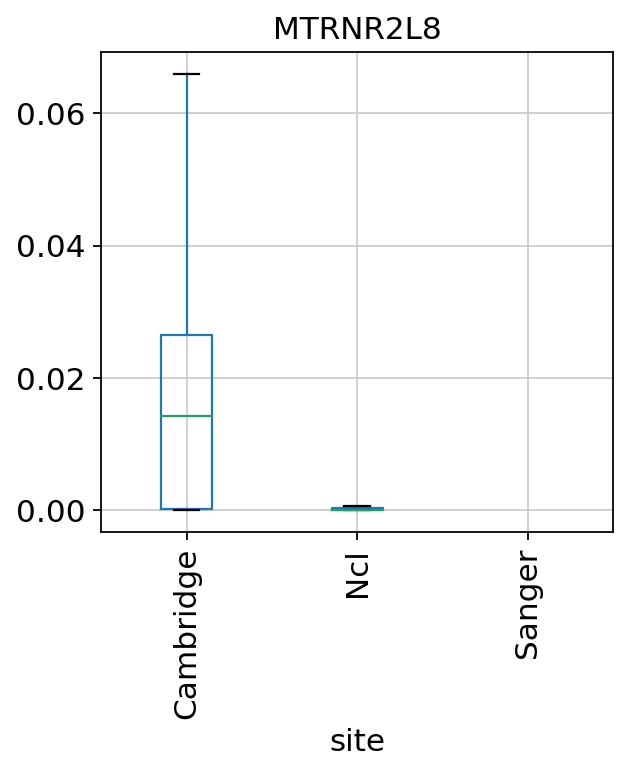

In [43]:
moderate_covid_expression.boxplot(
    by="site", column=["MTRNR2L8"], showfliers=False, rot=90
)
plt.suptitle("")

There are lots of outliers. Interestingly, the MTRNR2L8 gene has high levels of expression for the Cambridge site but much lower expression for the other two (perhaps due to how the sample was taken and processed). We can also look at other genes:

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


Text(0.5, 0.98, '')

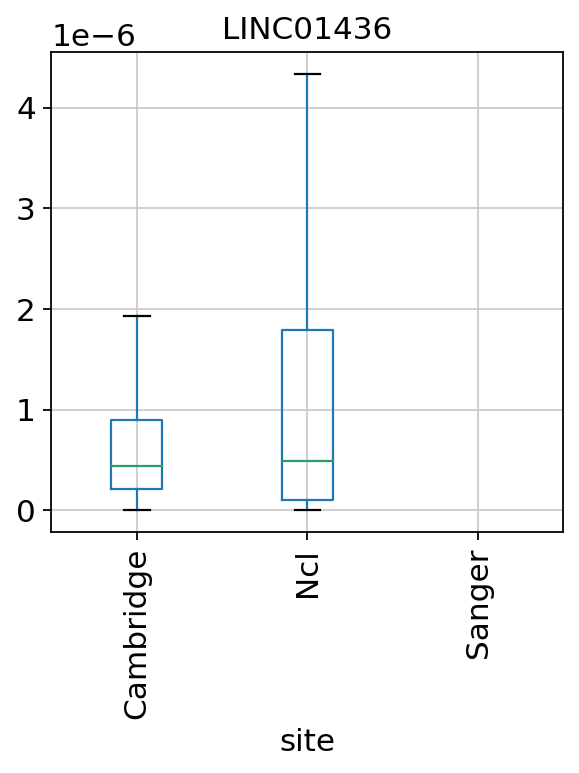

In [44]:
moderate_covid_expression.boxplot(
    by="site", column=["LINC01436"], showfliers=False, rot=90
)
plt.suptitle("")

We can repeat using other covariates to see how high S2B genes vary across covid status, age, etc.